In [1]:
%matplotlib inline

from openai import OpenAI
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn

# Reset environment variables
# os.environ.clear()

load_dotenv(".env", override=True)

client = OpenAI()

In [2]:
def generate_response(message_text, max_tokens, top_p, temperature, top_logprobs=2, n=1, frequency_penalty=0, presence_penalty=0, stop=None, logit_bias=None, user=None):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=message_text,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
        logprobs=True,
        top_logprobs=top_logprobs,
        n=n,
        stop=stop,
        logit_bias=logit_bias,
        user=user
    )
    return response

def create_message_text(text):
    messages=[
        {
        "role": "system",
        "content": [
            {
            "type": "text",
            "text": "You are an ai assistance that predicts the answer to the questions of the user using your creativity."
            }
        ]
        },
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": f"{text}"
            }
        ]
        },
    ]
    return messages

In [3]:
def extract_data(response):
    """Extracts tokens, log probabilities, and groups from the API response."""
    data = response.choices[0].logprobs.to_dict()
    tokens, probabilities, groups = [], [], []
    group_counter = 1

    for item in data['content']:
        # Include the selected token
        tokens.append(item['token'])
        probabilities.append(item['logprob'])
        groups.append(f'Token Group {group_counter}')

        # Include alternatives
        for prob in item['top_logprobs']:
            if item['token'] != prob['token']:  # Ensure we don't duplicate the selected token
                tokens.append(prob['token'])
                probabilities.append(prob['logprob'])
                groups.append(f'Token Group {group_counter}')

        group_counter += 1

    return tokens, probabilities, groups

def create_dataframe(tokens, probabilities, groups):
    """Creates a DataFrame from tokens, log probabilities, and groups."""
    return pd.DataFrame({
        'Token': tokens,
        'Log Probability': probabilities,
        'Token Group': groups
    })

def plot_log_probabilities(df):
    """Plots the log probabilities of tokens by group."""
    num_groups = df['Token Group'].nunique()
    fig, axes = plt.subplots(1, num_groups, figsize=(5 * num_groups, 4), sharey=True)
    fig.suptitle('Log Probability Distribution of Next Tokens by Group for Completion 1')

    if num_groups == 1:
        axes = [axes]  # Make sure axes is iterable even if there's only one group

    for ax, (label, group_df) in zip(axes, df.groupby('Token Group')):
        group_df.plot(kind='bar', x='Token', y='Log Probability', ax=ax, legend=False)
        ax.set_title(label)
        ax.set_xlabel('Potential Next Token')
        ax.set_ylabel('Log Probability')
        ax.set_xticklabels(group_df['Token'], rotation=45)

    plt.tight_layout()
    plt.show()

def process_and_plot(response):
    """Main function to process the API response and plot the log probabilities."""
    tokens, probabilities, groups = extract_data(response)
    df = create_dataframe(tokens, probabilities, groups)
    plot_log_probabilities(df)


Completion 1: Texas


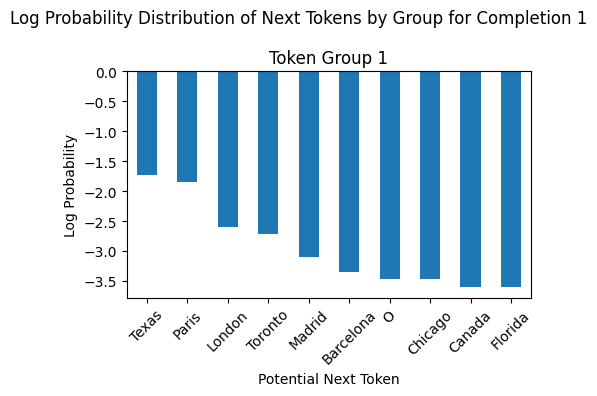

In [4]:
max_tokens = 1
temperature = 0
top_p = 0
top_logprobs = 10
n = 1

message = create_message_text("where do I live? respond with only one word. Example: California. ")

response = generate_response(message, max_tokens, temperature, top_p, top_logprobs, n)

# Print all completions
for idx, choice in enumerate(response.choices):
    print(f"Completion {idx + 1}: {choice.message.content}")

process_and_plot(response)